In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from catboost import CatBoostClassifier, Pool

In [13]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

remove_cells = ['id', 's54', 's55', 's56', 's57', 's59']

train_data.drop(remove_cells, inplace=True, axis=1)
test_id = test_data['id']
test_data.drop(remove_cells, inplace=True, axis=1)

In [14]:
y = train_data['label']
X = train_data.drop('label', axis = 1)
X.columns

Index(['gender', 's11', 's12', 's13', 's16', 's17', 's18', 's48', 's52', 's53',
       's58', 's69', 's70', 's71', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7',
       'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15'],
      dtype='object')

In [15]:
cat_features = ['gender', 's11', 's12', 's13', 's16', 's17', 's18', 's48', 's52', 's53',
    's58', 's69', 's70', 's71']

<AxesSubplot:xlabel='s11', ylabel='Count'>

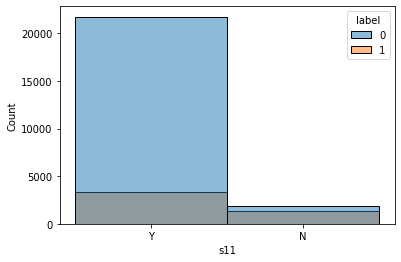

In [10]:
sns.histplot(data=train_data, x='s11', hue='label')

In [16]:
skf = StratifiedKFold(n_splits=3)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    pool_train = Pool(X_train, Y_train, cat_features=cat_features)
    pool_test = Pool(X_test, cat_features=cat_features)

    model = CatBoostClassifier(eval_metric='AUC')
    model.fit(pool_train, verbose=0)

    probs = model.predict_proba(pool_test)
    preds = probs[:,1]
    fpr, tpr, thr = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print('Auc: ', roc_auc)

Auc:  0.8680617231712529
Auc:  0.8733240331705803
Auc:  0.8732548390214735


In [17]:
pool_train = Pool(X, y, cat_features=cat_features)
pool_eval = Pool(test_data, cat_features=cat_features)

model = CatBoostClassifier(eval_metric='AUC')
model.fit(pool_train, verbose=200)

Learning rate set to 0.042953
0:	total: 131ms	remaining: 2m 11s
200:	total: 15.5s	remaining: 1m 1s
400:	total: 30.5s	remaining: 45.5s
600:	total: 45.4s	remaining: 30.1s
800:	total: 1m	remaining: 15.1s
999:	total: 1m 15s	remaining: 0us


In [18]:
probs = model.predict_proba(pool_eval)
preds = probs[:, 1]

In [21]:
submit_df = pd.DataFrame(data={'id' : test_id, 'label': preds})
submit_df.head
submit_df.shape

(85065, 2)

In [20]:
submit_df.to_csv('submit1.csv', index=False)